# Neural Network Exercise

Assignment:

Now, put neural networks into action. You are tasked with building a neural network using data from this kaggle competition. To complete the assignment, you will train and evaluate your model using only the train.csv. Remember, with Kaggle competitions; the test.csv does not include values for the target! The test.csv is only used for the competition, and you cannot evaluate your model using the test.csv without submitting your predictions to Kaggle.

Required Task:

Be sure to perform a train test split on the train.csv so you can evaluate your models.
Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one model.

Select your best model!

## Imports

In [30]:
# import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.max_columns',100)
rmse = RootMeanSquaredError()

In [2]:
# custom functions
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

## Load and Explore Data

In [3]:
# import data
df = pd.read_csv('Data/train.csv')

In [4]:
# preview data
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# check for missing values
df.isna().sum().sum()

6965

In [7]:
# check for duplicate values
df.duplicated().sum()

0

In [8]:
# drop unnecessary columns
df = df.drop(columns='Id')

In [9]:
# verify changes
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Train Test Split

In [10]:
# define X and y
X = df.drop(columns='SalePrice')
y = df['SalePrice']

In [11]:
# tts
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1023,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,7,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,14.0,Gd,TA,PConc,Gd,Gd,No,GLQ,16,Unf,0,1330,1346,GasA,Ex,Y,SBrkr,1504,0,0,1504,0,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2005.0,Fin,2,437,TA,TA,Y,156,20,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
810,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1384,50,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1.5Fin,6,5,1939,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,Mn,Rec,204,Unf,0,356,560,GasA,TA,Y,SBrkr,698,560,0,1258,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1939.0,Unf,1,280,TA,TA,P,0,0,0,0,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal
626,20,RL,NaN,12342,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,1960,1978,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,978,978,GasA,TA,Y,SBrkr,1422,0,0,1422,0,0,1,0,3,1,TA,6,Min1,1,TA,Attchd,1960.0,RFn,1,286,TA,TA,Y,0,0,36,0,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
813,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Gable,CompShg,MetalSd,MetalSd,BrkFace,243.0,TA,TA,CBlock,TA,TA,No,Rec,608,Unf,0,834,1442,GasA,Gd,Y,SBrkr,1442,0,0,1442,0,0,1,1,4,1,TA,7,Typ,0,NaN,Attchd,1958.0,RFn,1,301,TA,TA,Y,0,0,275,0,0,0,NaN,NaN,Shed,500,4,2007,COD,Normal


In [12]:
impute_na = SimpleImputer(strategy = 'constant', fill_value='NA')

In [13]:
num_cols = X_train.select_dtypes('number').columns
print('Numeric Columns:', num_cols)

impute_median = SimpleImputer(strategy = 'median')
scaler = StandardScaler()

num_pipe = make_pipeline(impute_median, scaler)
num_tuple = ('Numeric', num_pipe,num_cols)

num_tuple

Numeric Columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


('Numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
        'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
        'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
        'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
        'MoSold', 'YrSold'],
       dtype='object'))

In [14]:
ord_cols = ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageFinish', 'PavedDrive', 'Fence', 'Functional']
print('Ordinal Columns:',ord_cols)

bsmt_order = ["NA", 'Unf','LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
bsmt_exp_order = ['NA', 'No', 'Mn', 'Av', 'Gd']
gf_order = ['NA', 'Unf', 'RFn', 'Fin']
pd_order = ['N', 'P', 'Y']
f_order = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
func_order = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']

ord_catogory_order = [bsmt_order, bsmt_order, bsmt_exp_order, gf_order, pd_order, f_order, func_order]

ord_encoder = OrdinalEncoder(categories=ord_catogory_order)

ord_pipe = make_pipeline(impute_na, ord_encoder, scaler)
ord_tuple = ("Ordinal", ord_pipe,ord_cols)
ord_tuple

Ordinal Columns: ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageFinish', 'PavedDrive', 'Fence', 'Functional']


('Ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                              'ALQ', 'GLQ'],
                                             ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                              'ALQ', 'GLQ'],
                                             ['NA', 'No', 'Mn', 'Av', 'Gd'],
                                             ['NA', 'Unf', 'RFn', 'Fin'],
                                             ['N', 'P', 'Y'],
                                             ['NA', 'MnWw', 'GdWo', 'MnPrv',
                                              'GdPrv'],
                                             ['Sal', 'Sev', 'Maj2', 'Maj1',
                                              'Mod', 'Min2', 'Min1', 'Typ']])),
                 ('standardscaler', StandardScaler())]),
 ['B

In [15]:
ex_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
print("Ex list/Columns:", ex_list)

impute_na = SimpleImputer(strategy = 'constant', fill_value='NA')

ex_cond_order = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

ex_category_order = [ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order, 
                     ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order, ex_cond_order]

ex_encoder = OrdinalEncoder(categories = ex_category_order)

ex_pipe = make_pipeline(impute_na,ex_encoder, scaler)
ex_tuple = ("Ex columns", ex_pipe,ex_list)

ex_tuple

Ex list/Columns: ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']


('Ex columns',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                              'Ex'],
                                             ['NA', 'Po', 'Fa', 'TA'

In [16]:
ohe_cols=X_train.select_dtypes('object').drop(columns=ex_list+ord_cols).columns
print('OneHotEncoder Columns', ohe_cols)

impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_tuple = ("Onehotencoder", ohe_pipe, ohe_cols)
ohe_tuple

OneHotEncoder Columns Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
       'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')


('Onehotencoder',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
        'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition'],
       dtype='object'))

In [17]:
processor = ColumnTransformer([num_tuple, ohe_tuple, ord_tuple, ex_tuple])

## Fit and Transform

In [18]:
# fit and transform training data
X_train_tf = processor.fit_transform(X_train)

# transform test data
X_test_tf = processor.transform(X_test)

In [19]:
# preview transformed data
X_train_tf.head()

,Numeric__MSSubClass,Numeric__LotFrontage,Numeric__LotArea,Numeric__OverallQual,Numeric__OverallCond,Numeric__YearBuilt,Numeric__YearRemodAdd,Numeric__MasVnrArea,Numeric__BsmtFinSF1,Numeric__BsmtFinSF2,Numeric__BsmtUnfSF,Numeric__TotalBsmtSF,Numeric__1stFlrSF,Numeric__2ndFlrSF,Numeric__LowQualFinSF,Numeric__GrLivArea,Numeric__BsmtFullBath,Numeric__BsmtHalfBath,Numeric__FullBath,Numeric__HalfBath,Numeric__BedroomAbvGr,Numeric__KitchenAbvGr,Numeric__TotRmsAbvGrd,Numeric__Fireplaces,Numeric__GarageYrBlt,Numeric__GarageCars,Numeric__GarageArea,Numeric__WoodDeckSF,Numeric__OpenPorchSF,Numeric__EnclosedPorch,Numeric__3SsnPorch,Numeric__ScreenPorch,Numeric__PoolArea,Numeric__MiscVal,Numeric__MoSold,Numeric__YrSold,Onehotencoder__MSZoning_C (all),Onehotencoder__MSZoning_FV,Onehotencoder__MSZoning_RH,Onehotencoder__MSZoning_RL,Onehotencoder__MSZoning_RM,Onehotencoder__Street_Grvl,Onehotencoder__Street_Pave,Onehotencoder__Alley_Grvl,Onehotencoder__Alley_NA,Onehotencoder__Alley_Pave,Onehotencoder__LotShape_IR1,Onehotencoder__LotShape_IR2,Onehotencoder__LotShape_IR3,Onehotencoder__LotShape_Reg,...,Onehotencoder__CentralAir_Y,Onehotencoder__Electrical_FuseA,Onehotencoder__Electrical_FuseF,Onehotencoder__Electrical_FuseP,Onehotencoder__Electrical_NA,Onehotencoder__Electrical_SBrkr,Onehotencoder__GarageType_2Types,Onehotencoder__GarageType_Attchd,Onehotencoder__GarageType_Basment,Onehotencoder__GarageType_BuiltIn,Onehotencoder__GarageType_CarPort,Onehotencoder__GarageType_Detchd,Onehotencoder__GarageType_NA,Onehotencoder__MiscFeature_Gar2,Onehotencoder__MiscFeature_NA,Onehotencoder__MiscFeature_Othr,Onehotencoder__MiscFeature_Shed,Onehotencoder__MiscFeature_TenC,Onehotencoder__SaleType_COD,Onehotencoder__SaleType_CWD,Onehotencoder__SaleType_Con,Onehotencoder__SaleType_ConLD,Onehotencoder__SaleType_ConLI,Onehotencoder__SaleType_ConLw,Onehotencoder__SaleType_New,Onehotencoder__SaleType_Oth,Onehotencoder__SaleType_WD,Onehotencoder__SaleCondition_Abnorml,Onehotencoder__SaleCondition_AdjLand,Onehotencoder__SaleCondition_Alloca,Onehotencoder__SaleCondition_Family,Onehotencoder__SaleCondition_Normal,Onehotencoder__SaleCondition_Partial,Ordinal__BsmtFinType1,Ordinal__BsmtFinType2,Ordinal__BsmtExposure,Ordinal__GarageFinish,Ordinal__PavedDrive,Ordinal__Fence,Ordinal__Functional,Ex columns__ExterQual,Ex columns__ExterCond,Ex columns__BsmtQual,Ex columns__BsmtCond,Ex columns__HeatingQC,Ex columns__KitchenQual,Ex columns__FireplaceQu,Ex columns__GarageQual,Ex columns__GarageCond,Ex columns__PoolQC
1023,1.475911,-1.198986,-0.683950,0.637073,-0.515364,1.107889,1.020374,-0.519303,-0.944261,-0.284678,1.711873,0.642893,0.862092,-0.805280,-0.119821,-0.051643,-0.813995,-0.243017,0.772872,-0.766635,-1.112669,-0.207743,0.268177,0.591298,1.087084,0.293831,-0.192617,0.458853,-0.428838,-0.344584,-0.121808,-0.280154,-0.073333,-0.123489,-0.508139,0.137143,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.159374,-0.275466,-0.587879,1.429748,0.291012,-0.479057,0.247417,1.057489,-0.221841,0.578106,1.928638,0.890733,0.743356,1.193319,0.248474,0.253273,-0.070253
810,-0.871228,0.336917,-0.054883,-0.094926,0.390453,0.094543,0.682585,-0.023289,0.469362,2.166141,-1.279161,-0.046799,0.357895,-0.805280,-0.119821,-0.421692,1.119464,-0.243017,-1.062909,1.246471,0.128036,-0.207743,-0.963076,0.591298,-0.197370,0.293831,0.030695,1.295148,-0.718262,-0.344584,-0.121808,-0.280154,15.000378,-0.123489,-2.000860,-1.372124,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.682471,0.850040,-0.587879,0.305861,0.291012,2.799492,0.247417,-0.683790,-0.221841,-0.562482,0.114327,-2.222095,0.743356,0.088301,0.248474,0.253273,6.923091
1384,-0.167086,-0.452976,-0.152524,-0.094926,-0.515364,-1.049557,-1.681937,-0.60100

## Build Model

In [20]:
# define input_shape for input_dim argument
input_shape = X_train_tf.shape[1]

In [21]:
def build_model():
    model = Sequential()
    model.add(Dense(1000, input_dim = input_shape, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(250, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))

    model.compile(loss = 'mse', optimizer = 'adam', 
                  metrics = ['mae', rmse])
    return model

In [22]:
# instantiate model
model_1 = build_model()

In [23]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              230000    
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 250)               125250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                                 
Total params: 856,001
Trainable params: 856,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=5)

In [25]:
history = model_1.fit(X_train_tf, y_train, validation_data = (X_test_tf, y_test), epochs = 100, verbose = 0, callbacks = [early_stopping])

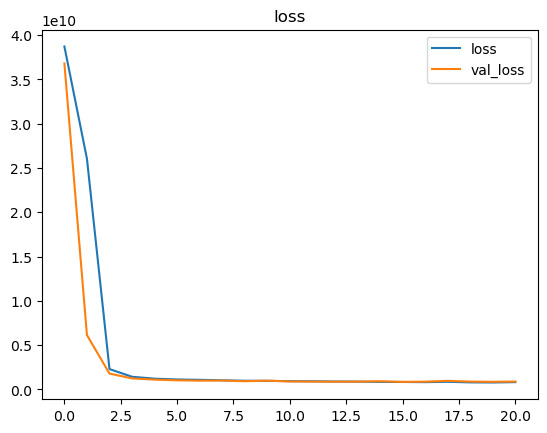

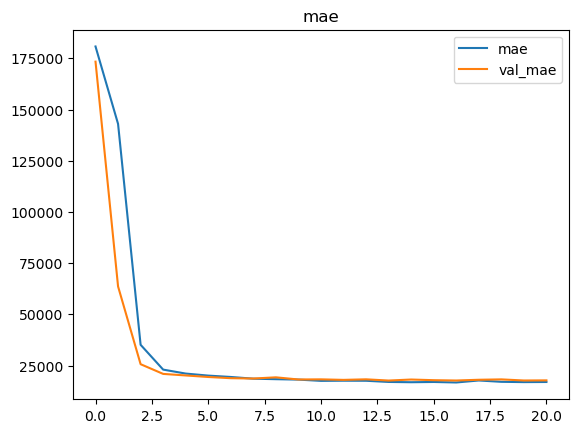

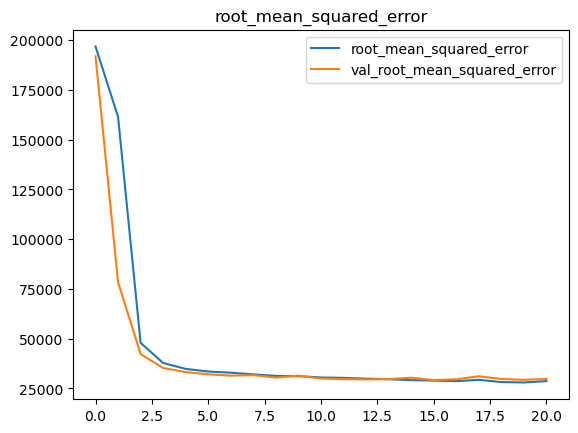

In [26]:
# use custom function to visualize metrics
plot_history(history);

## Model #1 Evaluation

In [31]:
# Make predictions and evaluate your model
train_preds = model_1.predict(X_train_tf)
test_preds = model_1.predict(X_test_tf)

train_scores = eval_regression(y_train, train_preds, name='base_reg_train')
test_scores = eval_regression(y_test, test_preds, name='base_reg_test')

reg_scores = pd.concat([train_scores, test_scores])
reg_scores

12/12 [==============================] - 0s 3ms/step


,RMSE,MAE,R2
Model Name,,,
base_reg_train,27318.694029,16152.004431,0.877079
base_reg_test,29802.529169,17739.567123,0.873212
